<a href="https://colab.research.google.com/github/JMhuautla/JMhuautla/blob/main/jose_huautla_algo_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting of a Stock Price: using *shallow* models to compare performance.

Date: June 2025

# Abstract

Applying machine learning models in time series forecasting, such as logistic regression or Gaussian Naive Bayes, can be seen as a benchmark for more complex models. Achieving the most success with the so-called *shallow* models teaches us about the capabilities and limitations of each. Although widely used before, the increasing software and hardware power allows us to implement more complex and powerful models like recurrent neural networks. This work builds the ground.

One common task relating to time series is predicting the future with past performance. Taking the time series and applying several transformations creates variables later used for feeding a model. Predicting the direction of the stock price (up or down) suffices the task, so the problem itself reduces to a supervised learning classification problem.

This project creates features given the Amazon stock price time series and implements several shallow models to compare its performance. Accuracy, in this context, is the selected metric to compare the results of the models.

# Imports

We start by importing the libraries to use and downloading the csv file with our Amazon stock price.

In [1]:
pip install feature_engine

In [2]:
# Import basic libraries
import pandas as pd
import numpy as np

# Library to create features
from feature_engine.timeseries.forecasting import WindowFeatures, LagFeatures


# Libraries for visualization
%matplotlib inline
from pylab import mpl, plt
plt.style.use('ggplot')
mpl.rcParams['font.family'] = 'serif'

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Metric
from sklearn.metrics import accuracy_score

# Data Download

We download the file and select the `AMZN.O` stock price time series.

In [3]:
# Download data
df = pd.read_csv('http://hilpisch.com/ref_eikon_eod_data.csv', index_col=0)

In [4]:
# Show first 2 rows
df.head(2)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.95,20.88,133.9,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.8


In [5]:
# Show last 2 rows
df.tail(2)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2019-06-28,197.92,133.96,47.87,1893.63,204.60,293.00,2941.76,15.08,1.1368,1409.1000,25.56,133.20
2019-07-01,201.55,135.68,48.05,1922.19,206.86,295.66,2964.33,14.06,1.1285,1384.0649,24.58,130.62


In [6]:
# Select the Amazon column as a dataframe
df = df[['AMZN.O']]

In [7]:
df.head(3)

,AMZN.O
Date,
2010-01-01,NaN
2010-01-04,133.90
2010-01-05,134.69


In [8]:
# Show dimension of the new dataset
df.shape

(2477, 1)

In [9]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2477 entries, 2010-01-01 to 2019-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN.O  2389 non-null   float64
dtypes: float64(1)
memory usage: 38.7+ KB


In [10]:
# Drop null values
df.dropna(inplace=True)

In [11]:
# Calculate basic stadistics
df.describe()

,AMZN.O
count,2389.000000
mean,615.855088
std,531.329918
min,108.610000
25%,222.930000
50%,358.660000
75%,842.700000
max,2039.510000


In [12]:
# Show duplicated values
df.duplicated().sum()

np.int64(42)

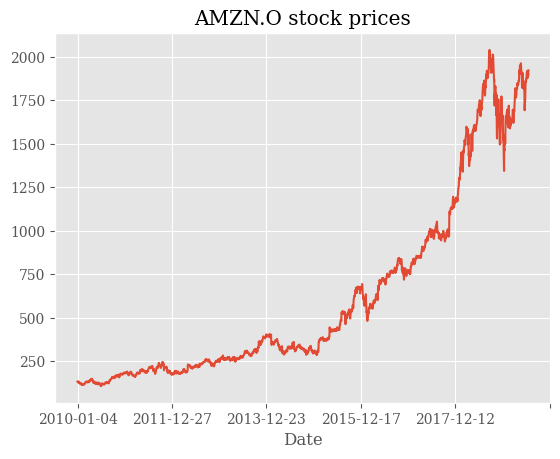

In [13]:
# Plot stock historical Amazon prices
df['AMZN.O'].plot(title='AMZN.O stock prices', x='date');

After selecting the historical prices of `AMZN.O` stock, we had to eliminate the null values. Checking for more errors in the dataset as duplicated values or imposible values (like negative prices) is always advisable. We have daily prices from January 2010 to July 2019.

## Data Stadistics & Feature Engineering

In the context of a supervised learning model, we need to feed the model with features and a target value. The latter will indicate if the price goes up (1) or down (-1). For the features, we will calculate the following:
  * Log return.
  * Smooth Moving Average of 30 and 90 days, as well as the difference between both.
  * Exponentially Weighted Moving Averages of 0 and 90 days, as well as the difference between both.
  * Two rolling volatilities of 30 and 90 days.

In [14]:
# Change "AMZN.0" for "price".
df.columns = ['price']

# Calculate the variable of log returns
df['log_returns'] = np.log(df['price'] / df['price'].shift())

# Drop rows with null values
df.dropna(inplace=True)

# Extract the direction of the movement up (positive) or down (negativebb)
df['target'] = np.where(df['log_returns'] > 0, 1, -1)

# Show first 3 rows of the new dataset
df.head(3)

,price,log_returns,target
Date,,,
2010-01-05,134.69,0.005883,1
2010-01-06,132.25,-0.018282,-1
2010-01-07,130.00,-0.017160,-1


Checking for the balance of classes is advisable when using the accuracy score as a metric. Dealing with a relatively high number of rises against downfalls will render the accuracy score misleading because the model could simply predict the most common one. Having roughly 50% percent of each is optimum.

In [15]:
# Check for class imbalance
df['target'].value_counts(normalize=True)

,proportion
target,
1,0.532663
-1,0.467337


Now, we create the moving averages and the rolling volatilities.

In [16]:
# Create an instance to implement the SMAs
wf = WindowFeatures(variables=['log_returns'], window=[10,90], functions=['mean', 'std'])

# Fit and transfom the df
df = wf.fit_transform(df)

# Calculates the short EWMA of 10 days
df['log_returns_10_ewma'] = df['log_returns'].ewm(min_periods=10, span=10).mean()

# Calculates the long EWMA of 90 days
df['log_returns_90_ewma'] = df['log_returns'].ewm(min_periods=90, span=90).mean()

# Eliminate rows with NaN values
df.dropna(inplace=True)

# Show the new df
df.head(3)


,price,log_returns,target,log_returns_window_10_mean,log_returns_window_10_std,log_returns_window_90_mean,log_returns_window_90_std,log_returns_10_ewma,log_returns_90_ewma
Date,,,,,,,,,
2010-05-14,128.533,-0.022593,-1,-0.007515,0.030769,-0.000203,0.021196,-0.005795,-0.000813
2010-05-17,128.910,0.002929,1,-0.006452,0.029956,-0.000520,0.021316,-0.004209,-0.000718
2010-05-18,126.280,-0.020613,-1,-0.006444,0.029959,-0.000284,0.021234,-0.007191,-0.001219


And calculate the differences among them.

In [17]:
# Difference between the long and short window for the SMAs
df['delta_sma'] = df['log_returns_window_90_mean'] - df['log_returns_window_10_mean']

#Difference between the long and short window for the volatility
df['delta_std'] = df['log_returns_window_90_std'] - df['log_returns_window_10_std']

# Difference between the long and short ewma
df['delta_ewma'] = df['log_returns_90_ewma'] - df['log_returns_10_ewma']

To evaluate the models, we will make in-sample _predictions_ and out-of-sample predictions. The former can be interpreted as how well the model can learn from the data. If the out-of-sample accuracy score is closer to that of the in-sample, we can say it has generalized the overall patterns correctly (at least to a certain degree).

We take the first 70% of the data for the train set for the fit and in sample predictions and the remnant for the test set.

In [18]:
# Create a the number in wich we have 70% of data
split = int(len(df) * 0.7)

# Training dataset
train = df.iloc[:split]

# Test dataset
test = df.iloc[split:]

With only a few exceptions, machine learning models do not perform well when the input numerical values have different scales, and hence, it is critical to do _feature scaling_. In this case, we normalize by taking the mean and dividing by its standard deviation to each element. Notice normalization comes before splitting to avoid data leakage from the train to the test sets.

In [19]:
# Create the set of columns to normalize
features = list(set(df.columns) - { 'target'})

In [20]:
# Normalize train set
train[features] = (train[features] - train[features].mean()) / train[features].std()
# Normalize test set
test[features] = (test[features] - test[features].mean()) / test[features].std()

/tmp/ipython-input-20-1701397258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = (train[features] - train[features].mean()) / train[features].std()
/tmp/ipython-input-20-1701397258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = (test[features] - test[features].mean()) / test[features].std()


Finally, since we want to predict the future with past data, we add 5 laggs per feature. These will be the input of the model.

In [21]:
# For the train set: create 5 lags per feature, drop the previous dataset and drop NaN values.
lf = LagFeatures(variables=features, periods=[1,2,3,4,5], drop_na=True, drop_original=True)
train = lf.fit_transform(train)

# For the test set: create 5 lags per feature, drop the rows with no lags and the resulted NaN values
lf = LagFeatures(variables=features, periods=[1,2,3,4,5], drop_na=True, drop_original=True)
test = lf.fit_transform(test)

# List of new features
features = list(set(train.columns)-{'target'})

# Show dimensions of the new datasets
print('Train set shape:{}. Test set shape:{}'.format(train.shape, test.shape))


Train set shape:(1603, 56). Test set shape:(685, 56)


## Model Implementation

Calculate in-sample and out-of-sample predictions for the following models: Gaussian naive Bayes, logistic regression, decision tree classifier, support vector classifier, and multi-layer perceptron classifier. Then, measure their accuracy performance. Note that a model that performs with less than 0.50 accuracy is no better than random guessing 50-50.

In [27]:
# Create instances for every model
gau = GaussianNB()
log = LogisticRegression(solver='liblinear')
dec = DecisionTreeClassifier(random_state=101010)
svc = SVC(random_state=101010)
mlp = MLPClassifier(alpha=0.001, random_state=101010)

# Create a list of the models to iterate
models = [gau, log, dec, svc, mlp]

# Fit, predict in and out-of-sample, an ccalculate accuracy per model
results = {}

for model in models:
  model.fit(train[features], train['target'])
  in_sample_acc = accuracy_score(train['target'], model.predict(train[features]))
  out_of_sample_acc = accuracy_score(test['target'], model.predict(test[features]))
  results[str(model)[:3]] = [in_sample_acc, out_of_sample_acc]

# With the results, create a dataframe
results = pd.DataFrame(data=results, index=['in-sample', 'out-of-sample']).round(4)

## Comparing results



In [28]:
# Show the results for each model
results

,Gau,Log,Dec,SVC,MLP
in-sample,0.5365,0.5490,1.0000,0.6532,0.6051
out-of-sample,0.4686,0.5051,0.5182,0.5007,0.5255


Gaussian naive Bayes is relatively good in the in-sample performance but fail egregiously to predict unseen data. The losgistic regression model reaches a better performance, although quite similar as random guessing. The decision tree classifier shows overfitting: high performance in seen data and really low in unseen data. It has a relatively decent performance nonetheless. SVC tends to do a good job in seen data, but fail in unseen data. The neural network also shows symptoms of overfitting, however, it reaches the highest accuracy score.

It is worth noting that this results did not requiere major adjustments in the hyperarrameters but those by defalut in the instances.

## Conclusions

Implementing shallow machine learning models grants us at least a small performance at the best scenario. Nonetheless, with no major adjustments, reaching the 50% minimum performance needed to beat random guessing is achievable. We can expect that with better hyperparameters or more complex models, a better accuracy level can be acquired.